# 0. Importar librerias

In [1]:
#Manejo de datos
import pandas as pd
import numpy as np
import scipy.stats as stats
import copy 

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# A/B Testing
import requests
from scipy.stats import ks_2samp
import random 

# 1. Cargar Datos

In [2]:
churn_future = pd.read_json('data/churn_future.json')

# 2. Probando API Rest

In [3]:
# REST API URL
CHURN_API_REST_URL = 'http://127.0.0.1:8000'

In [4]:
try:
    requests.get(CHURN_API_REST_URL)
    print("CHURN API REST is running, you can continue.")
except:
    print("CHURN API REST Is not running...")

CHURN API REST is running, you can continue.


# 3. A/B Testing

Para realizar el A/B testing correctamente, primero vamos a dividir nuestro dataset "churn_future" en 7, representando cada uno un día.

In [5]:
# Create new DF
ab_test_df = copy.deepcopy(churn_future)

# Shuffle DF
ab_test_df = ab_test_df.sample(frac=1).reset_index(drop=True)

# List of weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_copy = copy.copy(weekdays)
random.shuffle(weekdays_copy)

# Generate random weekdays with equal sizes
num_rows = len(ab_test_df)
random_weekdays = []

for _ in range(num_rows):
    random_weekdays.append(weekdays_copy.pop())
    # Shuffle list if it is empty
    if len(weekdays_copy) == 0:
        weekdays_copy = copy.copy(weekdays)
        random.shuffle(weekdays_copy)
        

# Add the 'Day' column to the DataFrame
ab_test_df['day'] = random_weekdays

Text(0.5, 1.0, 'Distribution by Day')

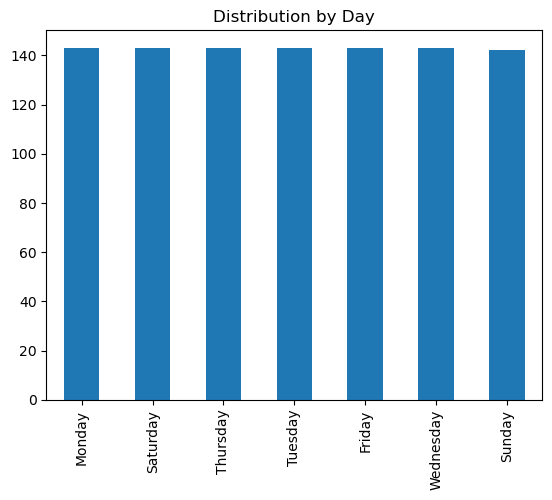

In [6]:
# Plot distribution by day
ab_test_df['day'].value_counts().plot.bar()
plt.title("Distribution by Day")

Ahora vamos a crear la función encargada de realizar las peticiones al API.

In [7]:
def make_predict_request(model_version, df):
    url = f'{CHURN_API_REST_URL}/{model_version}/predict'
    response = requests.post(url, json=df.to_dict(orient='records'))
    response_df = pd.DataFrame(response.json())
    df = pd.merge(df, response_df, on='customerID', how='inner')
    return df

Por último vamos a asignar aleatoriamente cuáles registros se correran con la primera o segunda versión del modelo.

In [8]:
# For each day
ab_test_df_final = pd.DataFrame()
index = 0
for day, split_df in ab_test_df.groupby('day'):
    # Assigning model version randomnly
    split_df = split_df.sample(frac=1).reset_index(drop=True)
    midpoint = len(split_df) // 2
    # First Version
    split_df['model_version'] = 1 if index % 2 == 0 else 2
    response_first_half = make_predict_request(1, split_df[:midpoint])
    # Second Version
    split_df.loc[midpoint:, 'model_version'] = 2 if index % 2 == 0 else 1
    response_second_half = make_predict_request(2, split_df[midpoint:])
    index += 1
    
    # Saving Df
    split_df = pd.concat([response_first_half, response_second_half])
    ab_test_df_final = pd.concat([ab_test_df_final, split_df])

Podemos comprobar que la mitad de los registros fueron procesados con la primera versión del modelo, y la otra mitad con la segunda versión.

Text(0.5, 1.0, 'Model version distribution')

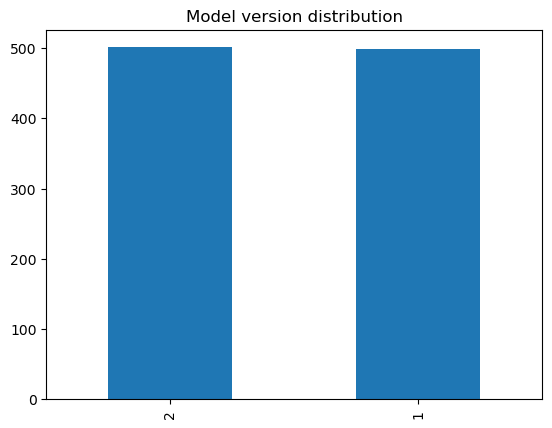

In [9]:
# Model version distribution
ab_test_df_final['model_version'].value_counts().plot.bar()
plt.title('Model version distribution')

Además. podemos comprobar que la versión del modelo se encuentra correctamente distribuida entre cada día.

Text(0.5, 1.0, 'Model version distribution by day')

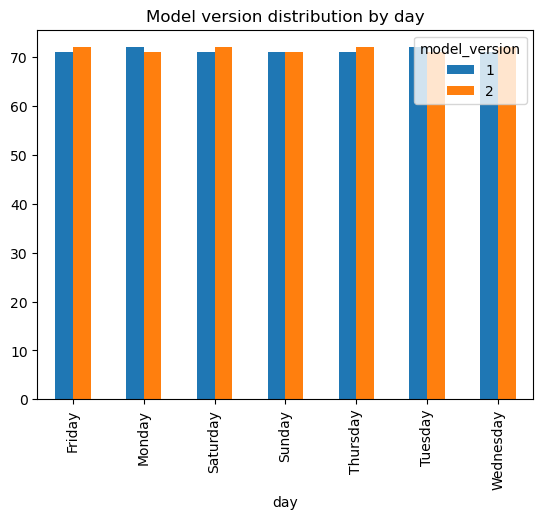

In [10]:
# Grouping the DataFrame by 'day' and 'model version', then counting occurrences
grouped = ab_test_df_final.groupby(['day', 'model_version']).size().unstack(fill_value=0)

# Plotting the data
grouped.plot(kind='bar')

plt.title('Model version distribution by day')

Finalmente, después de realizar las debidas peticiones al API, obtenemos nuevas columnas en nuestro Dataframe

In [11]:
# Fixing real churn value
ab_test_df_final = ab_test_df_final.replace({'Yes':1,'No':0})
# Final Data
ab_test_df_final[['customerID', 'Churn', 'model_version', 'churn_predicted', 'probability_churn']]

,customerID,Churn,model_version,churn_predicted,probability_churn
0,0634-SZPQA,1,1,0,0.461538
1,8659-HDIYE,0,1,0,0.000000
2,8685-WHQPW,1,1,0,0.136364
3,6127-IYJOZ,0,1,1,1.000000
4,6158-HDPXZ,0,1,1,0.525253
...,...,...,...,...,...
67,0376-OIWME,0,2,0,0.451504
68,0434-CSFON,0,2,1,0.520584
69,3585-ISXZP,1,2,1,0.674635
70,2954-PIBKO,0,2,0,0.005492


## 3.1 Distribución de probabilidades

Podemos observar que la distribución de las clases es la adecuada para el grupo en el que el churn es falso , ya que nuestros modelos marcaron que la probabilidad de churn fue menor a 0.5 para la mayoría. Sin embargo para la clase con churn verdadero no se ve una distribución adecuada.

También podemos notar que hay un desbalanceo entre clases, debido a que se presentan más registros con un churn falso que con un churn verdadero.

In [12]:
# Function to plot probabilities in churn groups

def kdeplot_churn(df, title):
    plt.figure(figsize=(15, 9))
    sns.kdeplot(data=df.loc[df["Churn"] == 1], x="probability_churn", bw_adjust=.3, label="1")
    sns.kdeplot(data=df.loc[df["Churn"] == 0], x="probability_churn", bw_adjust=.3, label="0")
    plt.axvline(x=.5, color="r", linestyle="--")
    plt.title(title)
    plt.legend()
    plt.show()

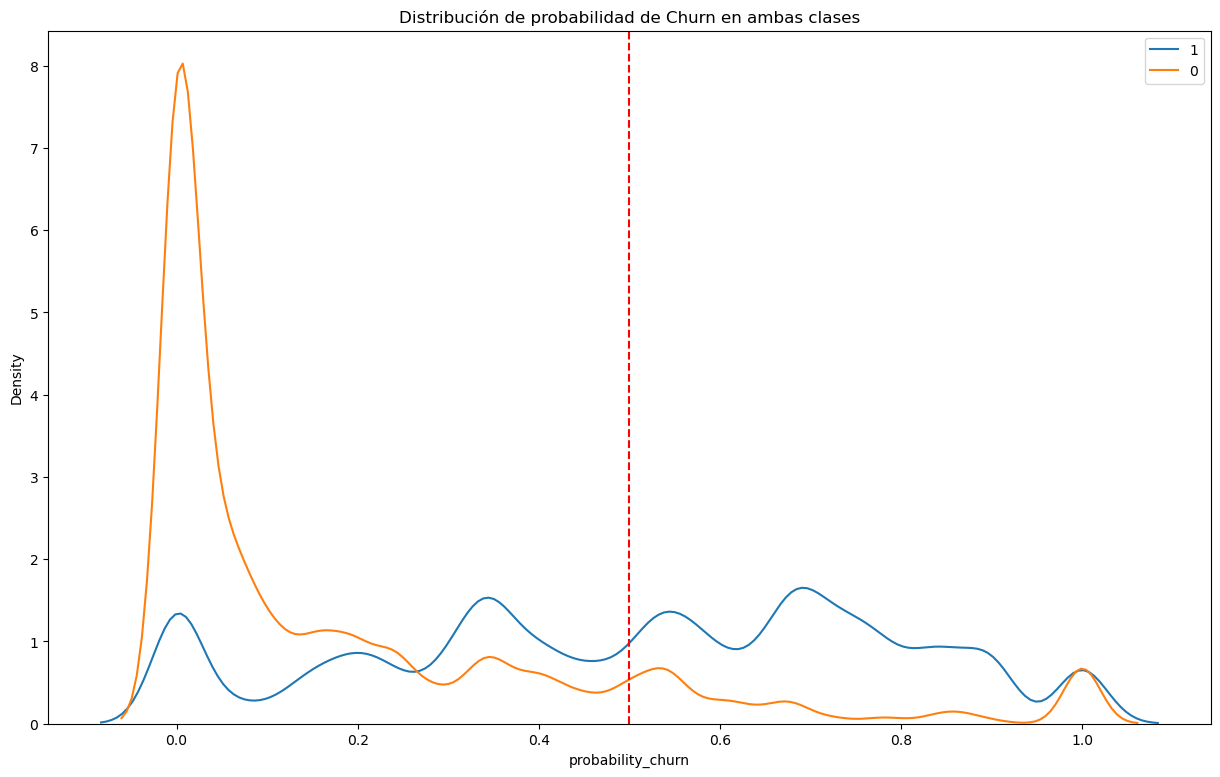

In [13]:
# KDEPlot for probabilities in churn groups
kdeplot_churn(ab_test_df_final, "Distribución de probabilidad de Churn en ambas clases")


Ahora, para saber si las diferencias de probabilidades son significativas entre ambas versiones del modelo vamos a proceder a hacer un test de Kosmogorov Smirnoff.

In [14]:
ks_results = []
ks_stat, p_value = ks_2samp(
    ab_test_df_final.loc[ab_test_df_final["model_version"] == 1, 'probability_churn'], 
    ab_test_df_final.loc[ab_test_df_final["model_version"] == 2, 'probability_churn']
)
print("KS stat:", ks_stat)
print("p-value:", p_value)

KS stat: 0.06094424377697511
p-value: 0.2938420248121284


El valor de KS es bastante bajo, por lo tanto podemos asegurar que la diferencia de las probabilidades entre ambas versiones del modelo, NO son significativas. Esto también lo podemos confirmar analizando cada modelo por separado.

### 3.1.1 Modelo Baseline

A continuación, podmeos ver que el modelo Baseline presenta problemas prediciendo correctamente los casos con churn verdadero.

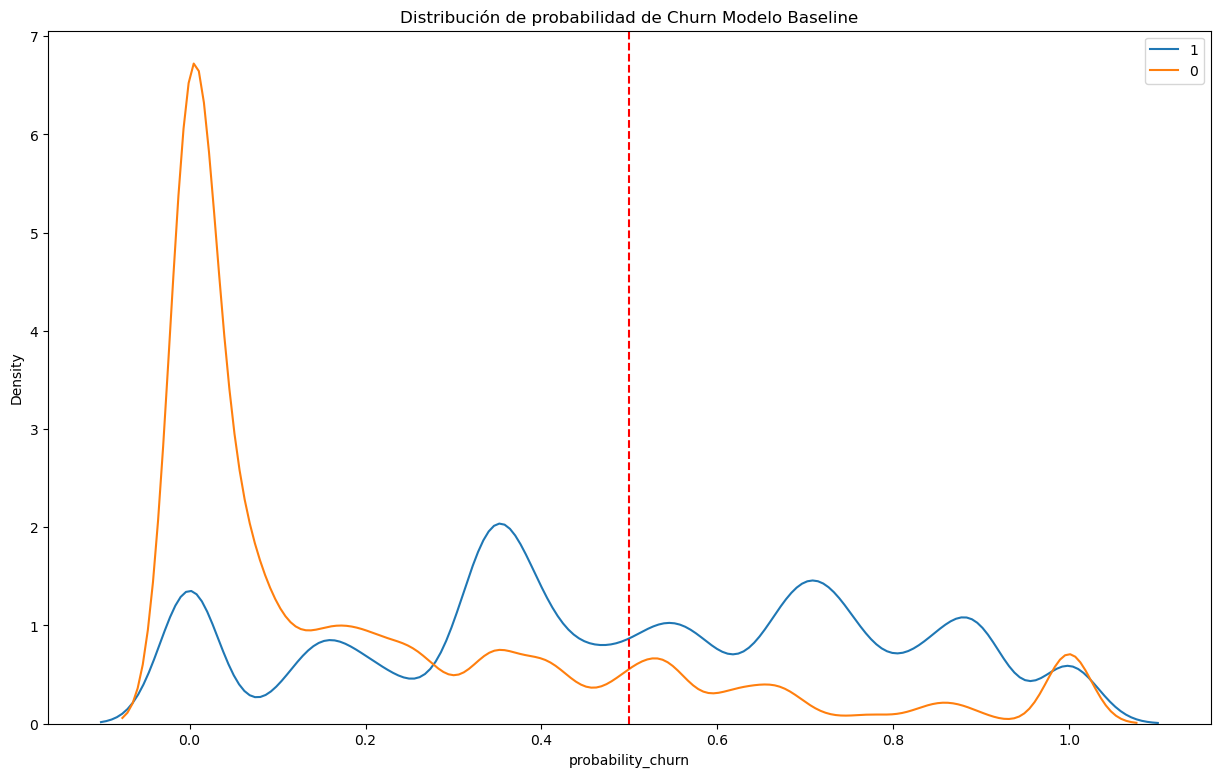

In [15]:
# Filtering model 1
predictions_model_v1 =  ab_test_df_final[ab_test_df_final['model_version'] == 1]
# KDEPlot for probabilities in churn groups
kdeplot_churn(predictions_model_v1, "Distribución de probabilidad de Churn Modelo Baseline")

### 3.1.2 Mejor Modelo

Finalmente, si analizamos la distribución de probabilidades solo en el mejor modelo. Podemos observar que se  comporta un poco mejor para la clase con churn verdadero, pero no significativamente mejor.

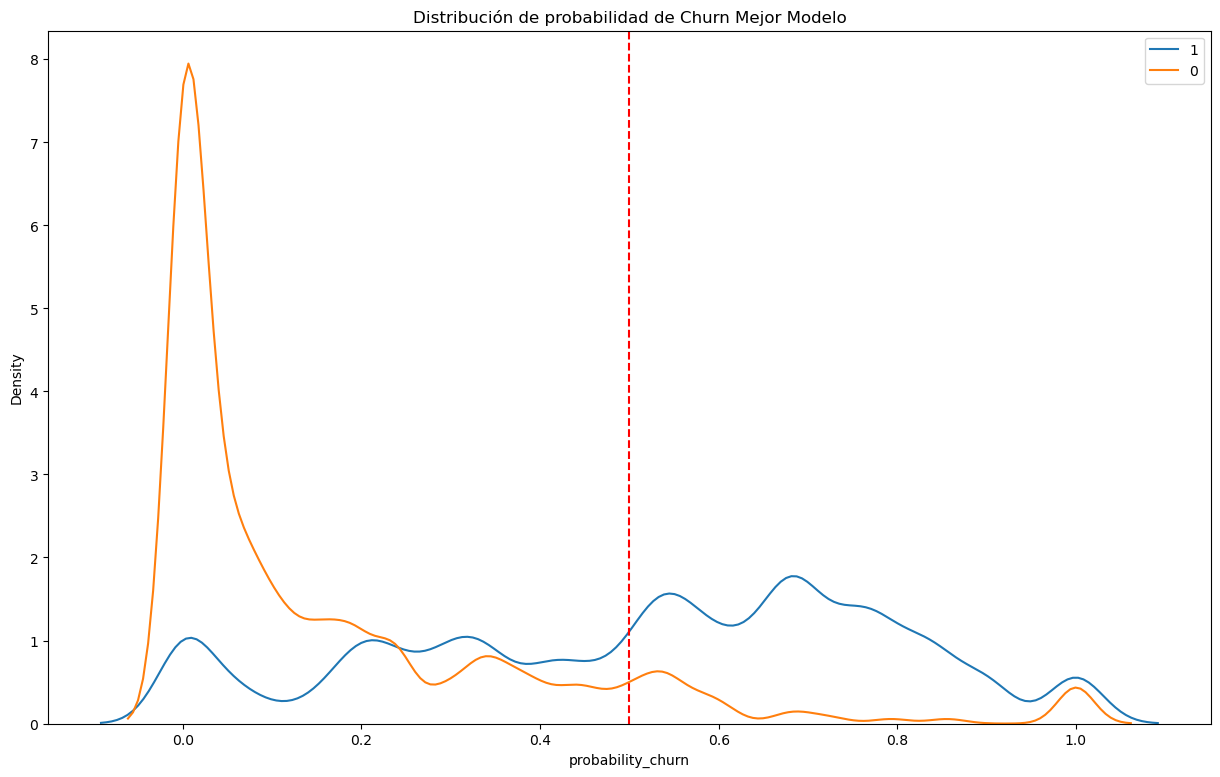

In [16]:
# Filtering model 1
predictions_model_v2 =  ab_test_df_final[ab_test_df_final['model_version'] == 2]
# KDEPlot for probabilities in churn groups
kdeplot_churn(predictions_model_v2, "Distribución de probabilidad de Churn Mejor Modelo")

## 3.2 Predicción de casos de churn Model Baseline vs Mejor Modelo

Ahora bien, vamos a contar, en porcentaje, cuántos usuarios fueron marcados con un churn verdadero por cada día.

In [17]:
# Counting churn predicted in each model per day
model_v1_count = predictions_model_v1[predictions_model_v1['churn_predicted'] == 1]['day'].value_counts(normalize=True)
model_v2_count = predictions_model_v2[predictions_model_v2['churn_predicted'] == 1]['day'].value_counts(normalize=True)
# Sorting by weekday
model_v1_count = model_v1_count[weekdays]
model_v2_count = model_v2_count[weekdays]

Si graficamos este conteo, podemos ver que ambos modelos predijeron un número similar de casos. Y en total, en un sólo día al rededor del 30% de usuarios son predichos como Churn verdadero.

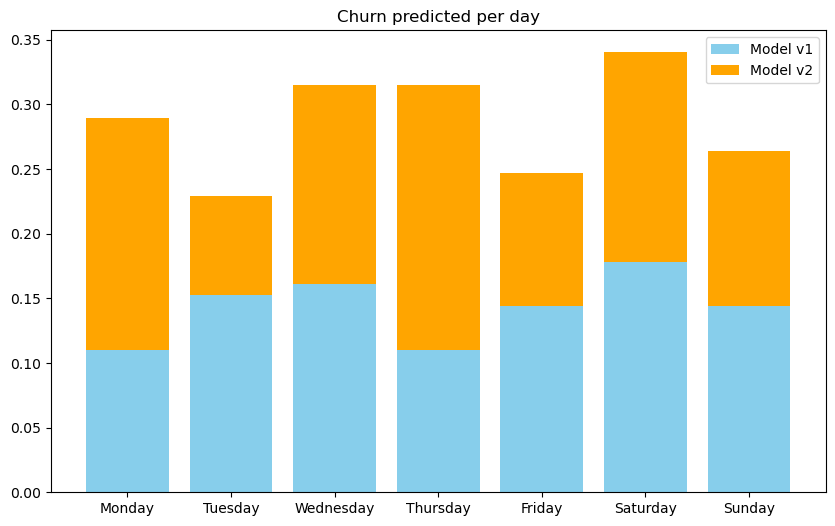

In [18]:
# Plot Churn predicted per day in each model
plt.figure(figsize=(10, 6))
plt.bar(weekdays, model_v1_count, color='skyblue', label='Model v1')
plt.bar(weekdays, model_v2_count, color='orange', bottom=model_v1_count, label='Model v2')
plt.title("Churn predicted per day")
plt.legend()

Finalmente podemos gráficar el incremento o decremento porcentual diario de predicción de casos de churn que tuvo el mejor modelo respecto al baseline.

Text(0.5, 1.0, 'Casos de Churn del mejor modelo respecto al Base line')

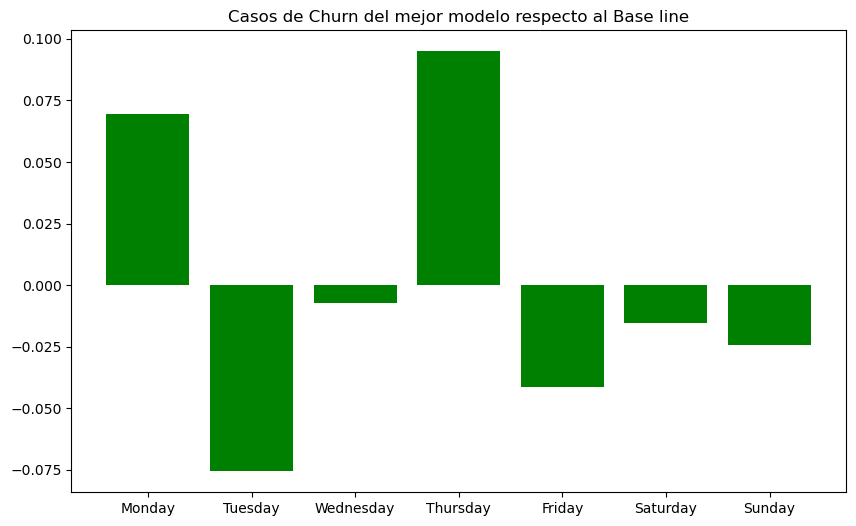

In [19]:
# Churn case increase or decrease
plt.figure(figsize=(10, 6))
differences = model_v2_count - model_v1_count
plt.bar(weekdays, differences.loc[weekdays], color='green', label='Model v1')
plt.title("Casos de Churn del mejor modelo respecto al Base line")

No podriamos concluir que el modelo baseline predice más o menos casos de Churn siempre. Debido a que no se tiene un comportamiento constante para todos los días.

## 3.3 Éxito prediciendo casos efectivos de Churn

Para cálcular el porcentaje de éxito del modelo prediciendo casos efectivos de Churn, vamos a calcular primero todos los casos reales de Churn por día.

In [20]:
# Churn True 
real_churn = ab_test_df_final[ab_test_df_final['Churn'] == 1]
total_count = real_churn['day'].value_counts()
# Sorting
total_count= total_count[weekdays]
total_count

Monday       39
Tuesday      24
Wednesday    44
Thursday     39
Friday       44
Saturday     41
Sunday       34
Name: day, dtype: int64

Ahora, vamos a contar cuántos de estos también fueron marcados como churn positivo con nuestro modelo.

In [21]:
# Predicted Churn
predicted_churn = real_churn[real_churn['churn_predicted'] == 1]
partial_count = predicted_churn['day'].value_counts()
# Sorting
partial_count = partial_count[weekdays]
partial_count

Monday       25
Tuesday      13
Wednesday    25
Thursday     22
Friday       20
Saturday     20
Sunday       18
Name: day, dtype: int64

Finalmente, vamos a calcular el procentaje de éxito prediciendo casos positivos de churn.

In [22]:
# Calculating percentage of success
success_rate = partial_count * 100 / total_count
success_rate

Monday       64.102564
Tuesday      54.166667
Wednesday    56.818182
Thursday     56.410256
Friday       45.454545
Saturday     48.780488
Sunday       52.941176
Name: day, dtype: float64

Text(0.5, 1.0, 'Success rate on a Daily basis')

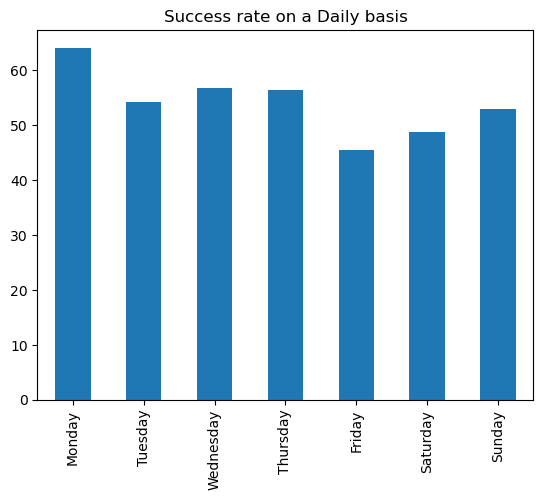

In [23]:
success_rate.plot.bar()
plt.title("Success rate on a Daily basis")